In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
import torch.nn.functional as F
from ModelsLib import Seq2Seq
from ModelsLib import DatasetTs
from tqdm import tqdm

In [24]:
training_set = pd.read_csv('train_ts_top5.csv', index_col='item_id')

In [25]:
training_set = training_set.T.values.reshape(-1, len(training_set))

In [26]:
train = training_set[:int(0.8 * len(training_set))]
valid = training_set[int(0.8 * len(training_set)):int(0.9 * len(training_set))]
test = training_set[int(0.9 * len(training_set)):]

In [27]:
test.shape

(195, 153)

In [28]:
def sliding_windows(data, seq_length, pred_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1-pred_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+pred_length+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc =  MinMaxScaler()
train = sc.fit_transform(train)
valid = sc.transform(valid)
test = sc.transform(test)

seq_length = 90
pred_length = 28

x_train, y_train = sliding_windows(train, seq_length, pred_length)
x_valid, y_valid = sliding_windows(valid, seq_length, pred_length)
x_test, y_test = sliding_windows(test, seq_length, pred_length)


trainX = Variable(torch.Tensor(np.array(x_train)))
trainy = Variable(torch.Tensor(np.array(y_train)))
validX = Variable(torch.Tensor(np.array(x_valid)))
validy = Variable(torch.Tensor(np.array(y_valid)))
testX = Variable(torch.Tensor(np.array(x_test)))
testy = Variable(torch.Tensor(np.array(y_test)))

In [29]:
n_features = trainX.shape[2] # number of timeseries 
hidden_dim = 60 * n_features # hidden dim
output_length = 28 # number of days to predict 

best_model = Seq2Seq(seq_length, n_features, hidden_dim, output_length)
best_model.load_state_dict(torch.load('best_model_n_features.pt'))
best_model.eval()

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(153, 9180, num_layers=3, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (rnn1): LSTM(153, 9180, num_layers=3, batch_first=True, dropout=0.3)
    (output_layer): Linear(in_features=9180, out_features=153, bias=True)
  )
)

In [30]:
BATCH_SIZE = 128
test = DatasetTs(testX, testy)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
preds = []

for X_test, y_test in tqdm(test_loader):
    prevs_y = X_test[:, -1:, :]
    seq_pred = best_model(X_test,prevs_y)
    preds.append(seq_pred)

  0%|                                                                                                                             | 0/1 [00:00<?, ?it/s]/home/dmaltsev/augmentation_timeseries_m5/ModelsLib.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = Variable(torch.tensor(X))
/home/dmaltsev/augmentation_timeseries_m5/ModelsLib.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return X, Variable(torch.tensor(self.y[index]))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:10<00:00, 130.68s/it]


In [32]:
preds = preds[0]

In [33]:
preds.shape, testy.shape

(torch.Size([76, 28, 153]), torch.Size([76, 28, 153]))

In [34]:
preds = preds.detach().numpy()
testy = testy.detach().numpy()

## Tests lstm vs naive

In [35]:
naive_base = testX[:, -1:, :].detach().numpy()

In [36]:
naive_pred = np.zeros((preds.shape))

for i in range(naive_pred.shape[0]):
    for j in range(naive_pred.shape[1]):
        for k in range(naive_pred.shape[2]):
            naive_pred[i, j, k] = naive_base[i, 0, k]

In [37]:
def MSE(x, y):
    return np.sqrt(np.mean((x - y) ** 2))

In [38]:
mse_days_naive = []
mse_days_lstm = []

for i in range(testy.shape[1]):
    mse_days_naive.append(MSE(testy[:, i, :], naive_pred[:, i, :]))
    mse_days_lstm.append(MSE(testy[:, i, :], preds[:, i, :]))

0.13902612813547577
0.77665937


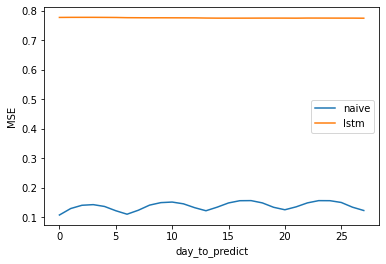

In [39]:
plt.plot(
    mse_days_naive,
    label='naive'
)

plt.plot(
    mse_days_lstm,
    label='lstm'
)

print(MSE(testy, naive_pred))
print(MSE(testy, preds))

plt.xlabel('day_to_predict')
plt.ylabel('MSE')
plt.legend()
plt.show()

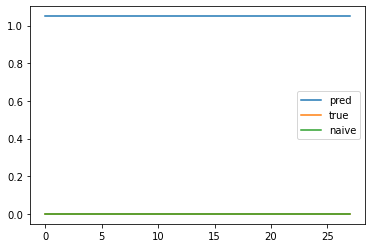

In [40]:
plt.plot(
    preds[50, :, 0],
    label='pred'
)

plt.plot(
    testy[50, :, 0],
    label='true'
)

plt.plot(
    naive_pred[50, :, 0],
    label='naive'
)

plt.legend()
plt.show()

In [37]:
testy

array([[[0.00042485, 0.00676041, 0.00131575, ..., 0.00165644,
         0.00100436, 0.00132036],
        [0.00046795, 0.01095187, 0.00106905, ..., 0.00118924,
         0.00090393, 0.00117365],
        [0.00049874, 0.00973499, 0.00205586, ..., 0.00227229,
         0.0014635 , 0.00146706],
        ...,
        [0.0005049 , 0.01230395, 0.00232998, ..., 0.00246342,
         0.00265438, 0.00244511],
        [0.00057879, 0.00892374, 0.00148022, ..., 0.00189004,
         0.00167872, 0.0022984 ],
        [0.00048643, 0.00797729, 0.00230257, ..., 0.00237847,
         0.00156393, 0.00102695]],

       [[0.00046795, 0.01095187, 0.00106905, ..., 0.00118924,
         0.00090393, 0.00117365],
        [0.00049874, 0.00973499, 0.00205586, ..., 0.00227229,
         0.0014635 , 0.00146706],
        [0.00060341, 0.0114927 , 0.00257668, ..., 0.00169891,
         0.00246786, 0.00298303],
        ...,
        [0.00057879, 0.00892374, 0.00148022, ..., 0.00189004,
         0.00167872, 0.0022984 ],
        [0.0